# Test post compute 3D

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import subprocess as sp
import sys
import os
import glob
import pickle 
import itertools

from matplotlib.colors import LogNorm, PowerNorm, Normalize
from ipywidgets import *

In [2]:
%matplotlib widget

In [3]:
### Transformation functions for image pixel values
def f_transform(x):
    return 2.*x/(x + 4.) - 1.

def f_invtransform(s):
    return 4.*(1. + s)/(1. - s)


### Spectral modules

In [4]:
## numpy code
def f_radial_profile_3d(data, center=(None,None)):
    ''' Module to compute radial profile of a 2D image '''
    
    z, y, x = np.indices((data.shape)) # Get a grid of x and y values
    
    center=[]
    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0, (z.max()-z.min())/2.0]) # compute centers
        
    # get radial values of every pair of points
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2+ + (z - center[2])**2)
    r = r.astype(np.int)
    
    # Compute histogram of r values
    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel()) 
    radialprofile = tbin / nr
    
    return radialprofile[1:-1]

def f_compute_spectrum_3d(arr):
    '''
    compute spectrum for a 3D image
    '''
#     GLOBAL_MEAN=1.0
#     arr=((arr - GLOBAL_MEAN)/GLOBAL_MEAN)
    y1=np.fft.fftn(arr)
    y1=np.fft.fftshift(y1)
#     print(y1.shape)
    y2=abs(y1)**2
    z1=f_radial_profile_3d(y2)
    return(z1)
   
def f_batch_spectrum_3d(arr):
    batch_pk=np.array([f_compute_spectrum_3d(i) for i in arr])
    return batch_pk

### Code ###
def f_image_spectrum_3d(x,num_channels):
    '''
    Compute spectrum when image has a channel index
    Data has to be in the form (batch,channel,x,y)
    '''
    mean=[[] for i in range(num_channels)]    
    sdev=[[] for i in range(num_channels)]    

    num=x.shape[0]
    for i in range(num_channels):
        arr=x[:,i,:,:,:]
        # print(i,arr.shape)
        batch_pk=f_batch_spectrum_3d(arr)
#         print(batch_pk)
        mean[i]=np.mean(batch_pk,axis=0)
        sdev[i]=np.var(batch_pk,axis=0)
    mean=np.array(mean)
    sdev=np.sqrt(np.array(sdev)/num)
    return mean,sdev


### Read data

In [5]:
# f1='/global/cfs/cdirs/m3363/vayyar/cosmogan_data/results_from_other_code/pytorch/results/3d_cGAN/20210723_72050_cgan_128_nodes1_lr0.00002_finetune/images/gen_img_label-0.5_epoch-17_step-4000.npy'
f1='/global/cfs/cdirs/m3363/vayyar/cosmogan_data/results_from_other_code/pytorch/results/3d_cGAN/20210723_72050_cgan_128_nodes1_lr0.00002_finetune/images/inference_label-0.5_epoch-10_step-2400.npy'
# f2='/global/cfs/cdirs/m3363/vayyar/cosmogan_data/results_from_other_code/pytorch/results/3d_cGAN/20210723_72050_cgan_128_nodes1_lr0.00002_finetune/images/gen_img_label-0.5_epoch-10_step-2360.npy'
f2='/global/cfs/cdirs/m3363/vayyar/cosmogan_data/results_from_other_code/pytorch/results/3d_cGAN/20210723_72050_cgan_128_nodes1_lr0.00002_finetune/images/inference_label-0.5_epoch-21_step-5070.npy'

a1=np.load(f1,mmap_mode='r')[:8,0,:,:,:]
a2=np.load(f2,mmap_mode='r')[:8,0,:,:,:]

# Input arrays are 4 D  (samples,x,y,z). Need to convert to 5D (samples, channels,x,y,z)

a1=np.expand_dims(a1,axis=1) # Convert 4D to 5D array
a2=np.expand_dims(a2,axis=1) # Convert 4D to 5D array
print(a1.shape,a2.shape)

(8, 1, 128, 128, 128) (8, 1, 128, 128, 128)


In [6]:
np.max(a1),np.max(a2)

(0.9977463, 0.992662)

Starting with a 5D array, compute the power spectrum.
5D array -> (samples, channel, x ,y ,z)

## Computing the power spectrum

In [7]:
y1,y1err=f_image_spectrum_3d(a1,1)
y2,y2err=f_image_spectrum_3d(a2,1)

## Convert 2D numpy array to 1D numpy array
y1=y1[0,:]
y1err=y1err[0,:]

y2=y2[0,:]
y2err=y2err[0,:]

print(y1.shape,y2.shape)

(108,) (108,)


##  Plot power spectrum

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
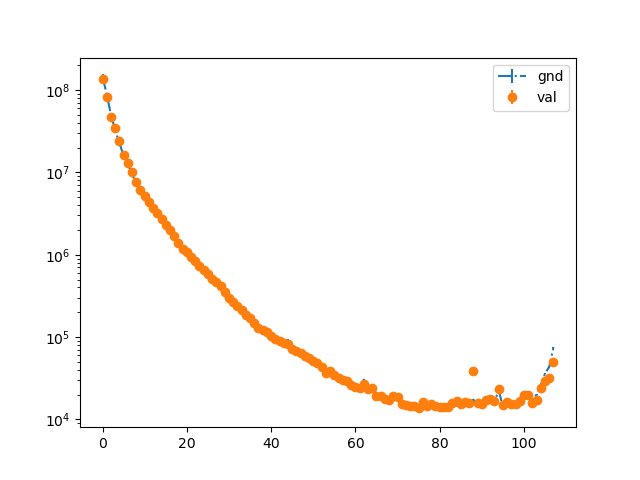

In [8]:
# Actual plot
size=y1.shape[0]
x=np.arange(0,size)
# y1=1.0/x**(4)
# y1err=[1e-6 for i in y1]

# y2=1.05/x**4+np.random.normal(0,1e-5,len(x))
# y2err=[1e-6 for i in y2]

plt.figure()
plt.errorbar(x,y1,y1err,marker='',linestyle='-.',label='gnd')
plt.errorbar(x,y2,y2err,marker='o',linestyle='',label='val')

plt.yscale('log')
plt.legend(loc='best')
plt.show()

## Relative power spectrum

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
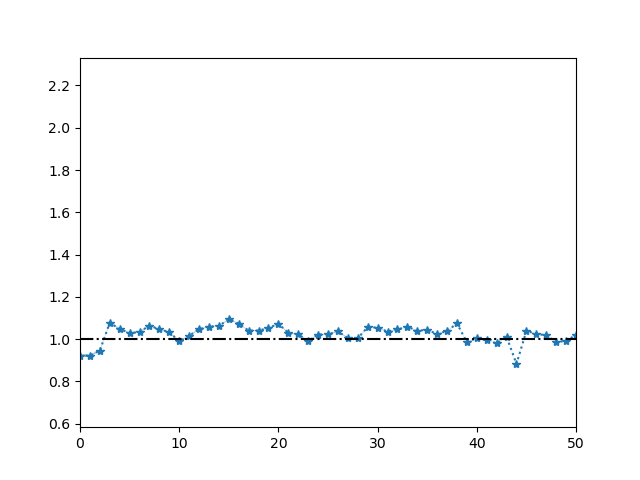

In [9]:
# Relative plot

plt.figure()
y=y2/(1.0*y1)
## Variance is sum of variance of both variables, since they are uncorrelated

# delta_r=sqrt(\delta_c2 ^ 2/ c1^2 + \delta_c1^2 * c_2^2 / c_1^4)
yerr=(np.abs(y))*np.sqrt((y1err/y1)**2+(y2err/y2)**2)/np.sqrt(size)

plt.fill_between(x, y - yerr, y + yerr, alpha=0.4)
plt.plot(x, y, marker='*', linestyle=':',label='a')
plt.xlim(0,50)

plt.axhline(y=1.0,color='k',linestyle='-.')

In [10]:
# ! jupyter nbconvert --to script 7_relative_specturm_for_SAM.ipynb